# Excitation probability

Try and follow Baragiola *et al.* in their conventions:
\begin{align}
    \operatorname{Var}[\xi_t^2]
    &=
    \frac{1}{\Omega^2}
    \\
    \operatorname{Var}[\xi_t]
    &=
    \sigma_T^2=\frac{2}{\Omega^2}
    \\
    \operatorname{Var}[\xi_\omega^2]
    &=
    \Omega^2
    \\
    \operatorname{Var}[\xi_\omega]
    &=
    \sigma_\omega^2=\frac{\Omega^2}{2}
\end{align}

\begin{align}
    \xi_{t,\mathrm{gau}}&=\sqrt[4]{\frac{\Omega^2}{2\pi}}\exp\left(\frac{\Omega^2(t-t_a)^2}{4}\right)
\end{align}

In [1]:
from functools import partial
import pickle
import numpy as np
from scipy.integrate import quad

from tqdm import tqdm_notebook

import pysme.hierarchy as hier


# #from quantum_utilities.qubits import Id, sigm, sigz, zero

In [2]:
# Define Lowering operator and Sigma Z

Id = np.eye(2, dtype=complex)

zero = np.zeros((2,2), dtype=complex)

sigz = np.array([[1, 0], [0, -1]], dtype=complex)

sigm = np.array([[0, 0], [1, 0]], dtype=complex)

In [3]:
def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

In [4]:
quad(lambda t: xi_gau(t, Omega=0.5, ta=0)**2, -3/0.5, 3/0.5)

In [5]:
rs = np.arcsinh(np.sqrt(np.arange(5)))

In [6]:
np.exp(rs)

array([1.        , 2.41421356, 3.14626437, 3.73205081, 4.23606798])

In [7]:
np.sinh(rs)**2

array([0., 1., 2., 3., 4.])

In [8]:
Omegas = np.power(2, np.linspace(-3, 3, 7))
Omegas

array([0.125, 0.25 , 0.5  , 1.   , 2.   , 4.   , 8.   ])

In [9]:
S = Id
L = sigm
H = zero

In [10]:
rho0 = (Id - sigz)/2

In [11]:
try:
    with open('2019-11-20-bandwidth-me-solns.pickle', 'xb') as f:
        n_maxs = [25]
        factories = {n_max: hier.HierarchyIntegratorFactory(2, n_max) for n_max in n_maxs}

        integrators = {}
        for r_idx in tqdm_notebook(range(len(rs)), desc='r'):
            r = rs[r_idx]
            for Omega_idx in tqdm_notebook(range(len(Omegas)), desc='Omega', leave=False):
                Omega = Omegas[Omega_idx]
                for n_max, factory in tqdm_notebook(factories.items(), desc='n_max', leave=False):
                    integrators[n_max,r_idx,Omega_idx] = factory.make_uncond_integrator(
                        partial(xi_gau, Omega=Omega, ta=0), S, L, H, r, mu=0)

        solns = {}
        for Omega_idx in tqdm_notebook(range(len(Omegas)), desc='Omega'):
            Omega = Omegas[-1-Omega_idx]
            times = np.linspace(-3/Omega, 3/Omega, 2**10+1)
            for r_idx in tqdm_notebook(range(len(rs)), desc='r', leave=False):
                r = rs[r_idx]
                for n_maxy in tqdm_notebook(n_maxs, desc='n_max', leave=False):
                    solns[n_max,r_idx,Omega_idx] = integrators[n_max,r_idx,Omega_idx].integrate(rho0, times)
        pickle.dump(solns, f)
except FileExistsError:
    print('Data already exist.')

/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/azaghal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [13]:
with open('2019-11-20-bandwidth-me-solns.pickle', 'rb') as f:
    solns = pickle.load(f)

In [14]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

In [17]:
solns.keys()

dict_keys([(25, 0, 0), (25, 1, 0), (25, 2, 0), (25, 3, 0), (25, 4, 0), (25, 0, 1), (25, 1, 1), (25, 2, 1), (25, 3, 1), (25, 4, 1), (25, 0, 2), (25, 1, 2), (25, 2, 2), (25, 3, 2), (25, 4, 2), (25, 0, 3), (25, 1, 3), (25, 2, 3), (25, 3, 3), (25, 4, 3), (25, 0, 4), (25, 1, 4), (25, 2, 4), (25, 3, 4), (25, 4, 4), (25, 0, 5), (25, 1, 5), (25, 2, 5), (25, 3, 5), (25, 4, 5), (25, 0, 6), (25, 1, 6), (25, 2, 6), (25, 3, 6), (25, 4, 6)])

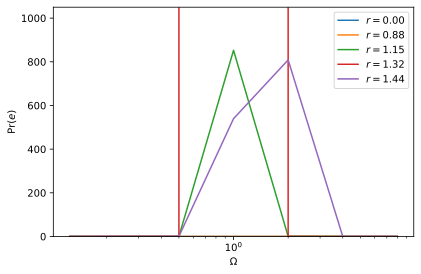

In [34]:
for r_idx in range(len(rs)):
    plt.semilogx(Omegas, [(solns[25,r_idx,Omega_idx].get_expectations(sigz, vac_rho(25)).max() + 1)/2
                          for Omega_idx in range(len(Omegas))],
                 label='$r={:.2f}$'.format(rs[r_idx]))
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\mathrm{Pr}(e)$')
plt.legend()
plt.ylim(-0.05, 1.05e3)
plt.tight_layout()